In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from patsy import dmatrix

In [2]:
df_test = pd.read_csv('C:/Users/dillo/OneDrive/Desktop/Kaggle Submission/Regression with an Abalone Dataset/playground-series-s4e4/test.csv')
df_train = pd.read_csv('C:/Users/dillo/OneDrive/Desktop/Kaggle Submission/Regression with an Abalone Dataset/playground-series-s4e4/train.csv')

Encoding 'Sex' for both the training data and test data

In [4]:
df_train['Sex'].value_counts()
dummies = pd.get_dummies(df_train['Sex'], dtype = int)
df_train = pd.concat([df_train, dummies], axis = 1).drop(['Sex'], axis = 1)

dummies = pd.get_dummies(df_test['Sex'], dtype = int)
df_test = pd.concat([df_test, dummies], axis = 1).drop(['Sex'], axis = 1)

In [5]:
id_col = "id"
target_col = "Rings"

y_train = df_train[target_col]
X_train = df_train.drop(target_col, axis = 1)

X_test = df_test

In [6]:
piecewise_feature = X_train.columns[1]
print(f"--- Creating Piecewise FEatures for: '{piecewise_feature}' ---")

--- Creating Piecewise FEatures for: 'Length' ---


In [7]:
knots = np.percentile(X_train[piecewise_feature], [25, 50, 75])
print(f"Knots placed at values: {np.round(knots, 4)}")

Knots placed at values: [0.445 0.545 0.6  ]


In [8]:
transformed_x_train = dmatrix(f"bs(train_data, knots = knots, degree = 1, include_intercept = False)",
                              {"train_data": X_train[piecewise_feature]}, 
                                return_type = 'dataframe')

In [9]:
transformed_x_test = dmatrix(f"bs(test_data, knots=knots, degree=1, include_intercept=False)",
                                 {"test_data": X_test[piecewise_feature]},
                                 return_type='dataframe')

In [10]:
X_train_final = pd.concat([X_train.drop(piecewise_feature, axis=1), transformed_x_train], axis=1)
X_test_final = pd.concat([X_test.drop(piecewise_feature, axis=1), transformed_x_test], axis=1)

In [11]:
X_train_final.columns = [f"col_{i}" for i in range(len(X_train_final.columns))]
X_test_final.columns = [f"col_{i}" for i in range(len(X_test_final.columns))]

In [12]:
print("\n--- Training Linear Regression Model on Transformed Features ---")
model = LinearRegression()
model.fit(X_train_final, y_train)
print("Model trained successfully.")


--- Training Linear Regression Model on Transformed Features ---
Model trained successfully.


In [31]:
print("\n--- Evaluating Model Performance on the training set ---")
y_pred_train = model.predict(X_train_final)


--- Evaluating Model Performance on the training set ---


In [25]:
mse = mean_squared_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)
rmse = np.sqrt(mse)

In [29]:
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Squared Error (MSE): 3.8629
R-squared (R2 Score): 0.6171
Root Mean Squared Error (RMSE): 1.9654


In [23]:
print("\n--- Model Coefficients ---")
coefficients = pd.DataFrame(model.coef_, X_train_final.columns, columns=['Coefficient'])
print(coefficients)


--- Model Coefficients ---
         Coefficient
col_0  -4.649177e-07
col_1  -2.238933e-01
col_2   1.563201e+01
col_3   5.454976e+00
col_4  -1.467220e+01
col_5  -4.903286e+00
col_6   2.274523e+01
col_7   2.193188e-01
col_8  -4.113392e-01
col_9   1.920204e-01
col_10  8.881784e-16
col_11  1.173732e+00
col_12  7.100467e-01
col_13 -1.954305e-02
col_14 -4.081536e+00


# Conceptual Question 8

In [33]:
import numpy as np
import matplotlib.pyplot as plt

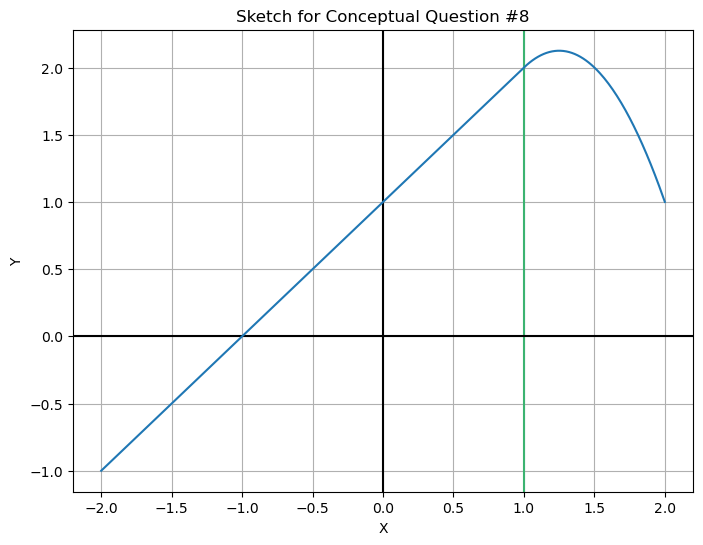

In [51]:
# Create the data
X = np.arange(-2, 2.01, 0.01)
Y = 1 + X + -2 * (X - 1)**2 * (X >= 1)
# Create the plot
plt.figure(figsize=(8, 6))
# Add vertical lines
plt.axvline(x=0, color='black')
plt.axvline(x=1, color='mediumseagreen')
# Add horizontal line
plt.axhline(y=0, color='black')
# Add the main line plot
plt.plot(X, Y, linewidth=1.5)
# Add labels and title for context
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Sketch for Conceptual Question #8")
# Display the plot
plt.grid(True)
plt.show()

## Applied Question #8

In [5]:
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Stats libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# Scikit-learn for CV and preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline

# Spline and GAM libraries
from patsy import dmatrix

# Set a random seed for reproducibility
np.random.seed(42)

# Load the data from the ISLR author's website
# The original dataset uses '?' for missing values.
try:
    Auto = pd.read_csv('https://www.statlearning.com/s/Auto.csv', na_values='?').dropna()
except Exception:
    print("Could not download the dataset. Please check your internet connection or place 'Auto.csv' in the current directory.")
    # Fallback for offline use
    Auto = pd.read_csv('Auto.csv', na_values='?').dropna()


# Set a default plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (8, 6)

print("Data loaded successfully. Shape:", Auto.shape)
print(Auto.head())


Data loaded successfully. Shape: (392, 9)
    mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0       130.0    3504          12.0    70   
1  15.0          8         350.0       165.0    3693          11.5    70   
2  18.0          8         318.0       150.0    3436          11.0    70   
3  16.0          8         304.0       150.0    3433          12.0    70   
4  17.0          8         302.0       140.0    3449          10.5    70   

   origin                       name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino  


## Correlation Matrix

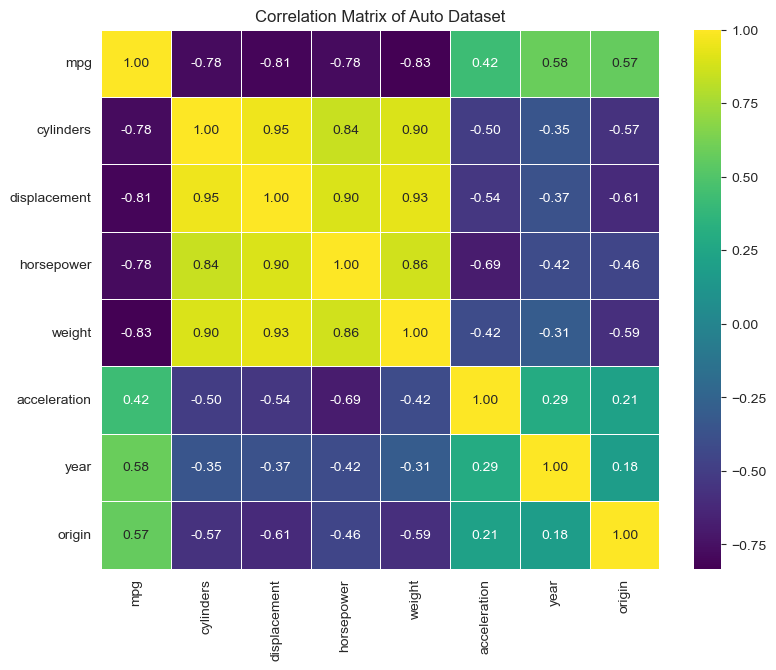

In [8]:
# Create a correlation matrix of the numeric columns
corr_matrix = Auto.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Auto Dataset')
plt.show()

## Piecewise Regression

Is there evidence of a non-linear relationships in this dataset? Yes. Horsepower and MPG have a non-linear relationship. 

Below shows this non-linear relationship with piecewise regression and spline regression. 

--- Piecewise Regression Summary ---
Knot at horsepower = 95
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   54.5672      1.653     33.016      0.000      51.318      57.817
horsepower                                  -0.3416      0.020    -17.107      0.000      -0.381      -0.302
I((horsepower - 95) * (horsepower > 95))     0.2394      0.025      9.617      0.000       0.190       0.288


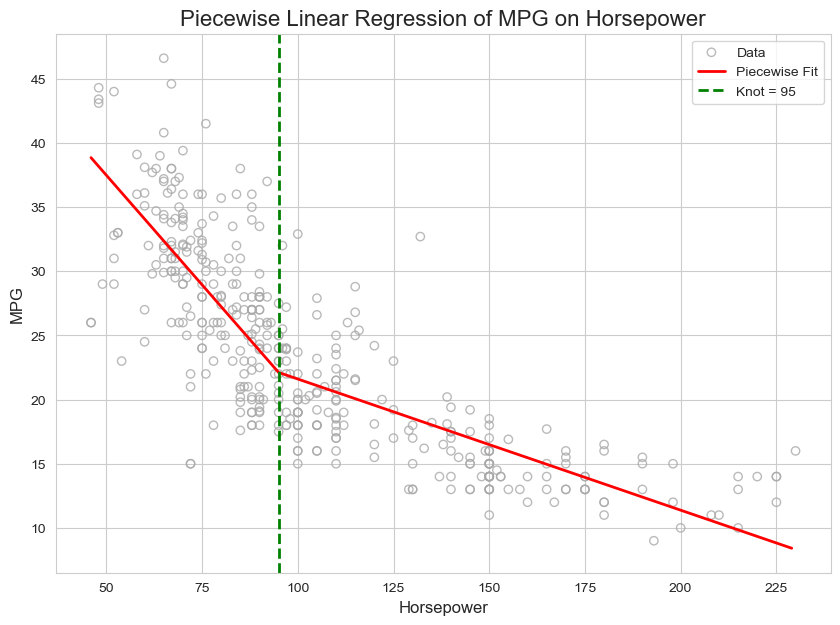

In [27]:

knot = 95

piecewise_formula = f'mpg ~ horsepower + I((horsepower - {knot}) * (horsepower > {knot}))'

# Fit the model
fit_piecewise = smf.ols(piecewise_formula, data=Auto).fit()

# Print the model summary to see the coefficients
print("--- Piecewise Regression Summary ---")
print(f"Knot at horsepower = {knot}")
print(fit_piecewise.summary().tables[1])

# Create a dataframe from the horsepower grid for prediction
hp_grid_df = pd.DataFrame({'horsepower': hp_grid})
preds_piecewise = fit_piecewise.predict(hp_grid_df)


# Plot the results
plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")

# Plot the raw data
plt.scatter(Auto['horsepower'], Auto['mpg'], facecolors='none', edgecolors='darkgrey', alpha=0.8, label='Data')

# Plot the piecewise regression line
plt.plot(hp_grid, preds_piecewise, color='red', linewidth=2, label='Piecewise Fit')

# Add a vertical line to show the knot location
plt.axvline(x=knot, color='green', linestyle='--', linewidth=2, label=f'Knot = {knot}')

# Add labels and title
plt.xlabel('Horsepower', fontsize=12)
plt.ylabel('MPG', fontsize=12)
plt.title('Piecewise Linear Regression of MPG on Horsepower', fontsize=16)
plt.legend()
plt.show()


## Spline Regression

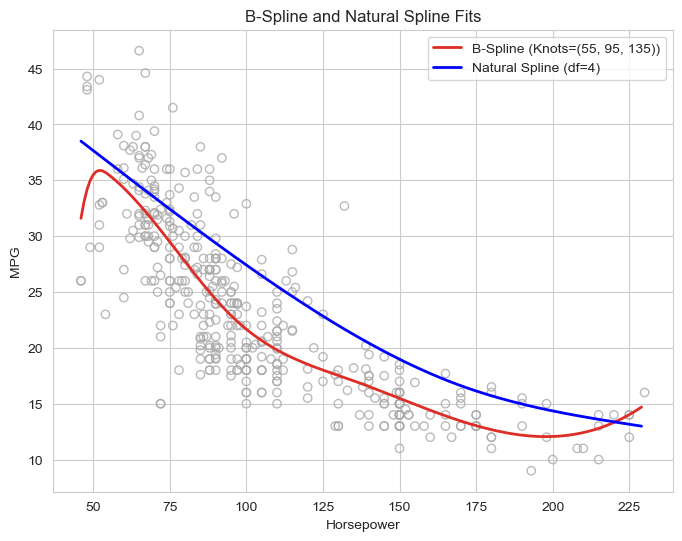

In [29]:
# Generate a grid for horsepower values for plotting
hplims = (Auto['horsepower'].min(), Auto['horsepower'].max())
hp_grid = np.arange(hplims[0], hplims[1])

knots = (55, 95, 135)
X_bs_train = sm.add_constant(dmatrix(f"bs(horsepower, knots={knots}, degree=3, include_intercept=False)", {"horsepower": Auto['horsepower']}, return_type='dataframe'))
X_bs_pred = sm.add_constant(dmatrix(f"bs(horsepower, knots={knots}, degree=3, include_intercept=False)", {"horsepower": hp_grid}, return_type='dataframe'))

fit_bs = sm.GLS(Auto['mpg'], X_bs_train).fit()
pred_bs = fit_bs.predict(X_bs_pred)

df = 4
X_ns_train = sm.add_constant(dmatrix(f"cr(horsepower, df={df})", {"horsepower": Auto['horsepower']}, return_type='dataframe'))
X_ns_pred = sm.add_constant(dmatrix(f"cr(horsepower, df={df})", {"horsepower": hp_grid}, return_type='dataframe'))
                                      
fit_ns = sm.GLS(Auto['mpg'], X_ns_train).fit()
pred_ns = fit_ns.predict(X_ns_pred)


# Plotting the splines
plt.scatter(Auto['horsepower'], Auto['mpg'], facecolors='none', edgecolors='darkgrey', alpha=0.8)
plt.plot(hp_grid, pred_bs, color='#de2d26', linewidth=2, label=f"B-Spline (Knots={knots})")
plt.plot(hp_grid, pred_ns, color='blue', linewidth=2, label=f"Natural Spline (df={df})")
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.title('B-Spline and Natural Spline Fits')
plt.legend()
plt.show()